# Part 6 - Google Trends data

- toc: True
- badges: true
- comments: true
- categories: [jupyter]

In [1]:
import os
import sys
import datetime
import inspect
import pandas as pd
import pytrends
from pytrends.request import TrendReq


In [2]:
mlist = list(filter(lambda x: inspect.ismodule(x[1]), locals().items()))
vi = sys.version_info
print("version {0}.{1}.{2} of Python".format(vi.major, vi.minor, vi.micro))
for name, mod in mlist:
    if name.startswith("__"):
        continue
    if hasattr(mod, "__version__"):
        print("version {1} of {0}".format(name, mod.__version__))
del mod
del name

version 3.8.5 of Python
version 1.1.3 of pd


In [3]:
pytrends = TrendReq(hl='en-US', tz=360)
kw_list = [  "work from home",  "unemployment", "indeed jobs", "work"]
# "unemployment", "job" " ui online"
#,'hire', "Jobs", "vacancy", "employment", "unemployment", "benefits"] "njuifile"
nweeks = 200
end_date = datetime.date.today().strftime("%Y-%m-%d")
start_date = (datetime.date.today() - datetime.timedelta(weeks=nweeks)).strftime("%Y-%m-%d")
timeframe = start_date+ " " + end_date  
print(timeframe)
geo = 'US'
pytrends.build_payload(kw_list, cat=60, timeframe=timeframe, geo=geo, gprop='')

2017-01-04 2020-11-04


In [4]:
df = pytrends.interest_over_time()

<AxesSubplot:xlabel='date'>

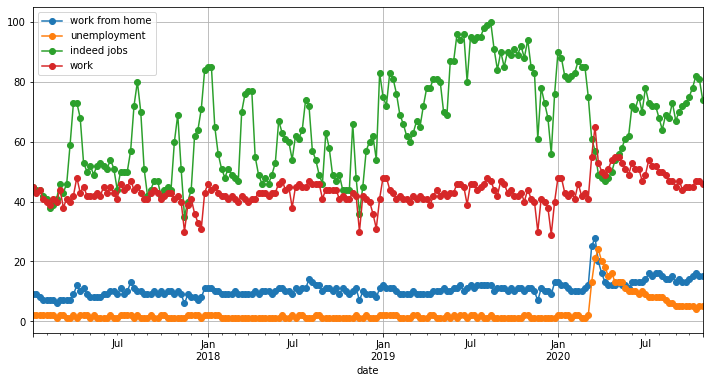

In [5]:
df.plot(figsize=[12,6], grid=True, marker='o')

In [6]:
pytrends.suggestions("job")

[{'mid': '/m/04115t2', 'title': 'Job', 'type': 'Topic'},
 {'mid': '/m/07s_c', 'title': 'Unemployment', 'type': 'Topic'},
 {'mid': '/m/01rbb', 'title': 'Crime', 'type': 'Topic'},
 {'mid': '/m/019323', 'title': 'Duty', 'type': 'Topic'},
 {'mid': '/g/1211q_qf', 'title': 'job', 'type': 'Topic'}]

In [7]:
dir(pytrends)
related = pytrends.related_queries()
related.keys()

dict_keys(['work from home', 'unemployment', 'indeed jobs', 'work'])

In [8]:
from collections import deque
import time

def build_payload(pytrends, kw, nweeks=100, geo='US', cat=60):
    end_date = datetime.date.today()
    start_date = datetime.date.today() - datetime.timedelta(weeks=nweeks)
    timeframe = start_date.strftime("%Y-%m-%d") + " " + end_date.strftime("%Y-%m-%d")  
    pytrends.build_payload([kw], cat=cat, timeframe=timeframe, geo=geo, gprop='')    
    return pytrends

sleeptime = 0.05
verbosity = 1
max_keywords = 100
min_score = 70

keywords2try = deque()
keyword_tups = deque()
keyword_set = set()

# seed the queue with a few terms
keywords2try.appendleft(("jobs", 101, 0, 'root', 101))
keywords2try.appendleft(("unemployment", 101, 0, 'root', 101))
print("Start {0}".format(datetime.datetime.now()))
while len(keywords2try) > 0:
    if len(keyword_tups) > max_keywords:
        break
    kw, score, level, parent, parent_score = keywords2try.pop()
    if kw in keyword_set:
        if verbosity > 1:
            print("{0} already in set".format(kw))
        continue
    if verbosity > 0:
        print("<kw#{1}='{0}''>, ".format(kw, len(keyword_tups)+1), end='')
    # add to keyword_tups and keyword_set
    keyword_tups.appendleft((kw, score, level, parent, parent_score))
    keyword_set.add(kw)
    pytrends = TrendReq(hl='en-US', tz=360)    
    pytrends = build_payload(pytrends, kw)
    time.sleep(.5)
    related = pytrends.related_queries()
    if not related:
        if verbosity > 1:
            print("\t No related")
        continue
    if 'top' not in related[kw].keys():
        if verbosity > 1:
            print("\tNo top")
        continue
    df = related[kw]['top']
    if df is None:
        if verbosity > 1:
            print("\ttop is empty")
        continue
    for tup in df.itertuples():
        child_score = score * tup.value/float(100)
        if child_score > min_score and tup.query not in keyword_set:
            if verbosity > 1:
                print("\tpushing {0}".format(tup.query))
            keywords2try.appendleft((tup.query, child_score, level+1, kw, score))
print("Done {0}".format(datetime.datetime.now()))
kw_df = pd.DataFrame(data=list(keyword_tups), columns=['keyword', 'score', 'level','parent', 'parent_score']).sort_values(by="score", ascending=False)
kw_df.head()

Start 2020-11-04 23:01:31.677058
<kw#1='jobs''>, <kw#2='unemployment''>, <kw#3='jobs near me''>, <kw#4='jobs indeed''>, <kw#5='unemployment jobs''>, <kw#6='part time unemployment''>, <kw#7='jobs hiring near me''>, <kw#8='indeed jobs near me''>, <kw#9='unemployment login''>, <kw#10='unemployment office''>, <kw#11='unemployment benefits''>, <kw#12='file for unemployment''>, <kw#13='florida unemployment''>, <kw#14='texas unemployment''>, <kw#15='unemployment rate''>, <kw#16='tn.gov jobs''>, <kw#17='unemployment for part time''>, <kw#18='unemployment part time work''>, <kw#19='hiring jobs near me part time''>, <kw#20='jobs near me hiring part time''>, <kw#21='jobs hiring near me indeed''>, <kw#22='unemployment wi''>, <kw#23='wi unemployment login''>, <kw#24='wisconsin unemployment login''>, <kw#25='unemployment office near me''>, <kw#26='part time unemployment benefits''>, <kw#27='can part time file for unemployment''>, <kw#28='how to file for unemployment''>, <kw#29='careersource''>, <kw#

,keyword,score,level,parent,parent_score
78,jobs,101.0,0,root,101.0
77,unemployment,101.0,0,root,101.0
34,dwd unemployment wi login,101.0,4,wi unemployment login,101.0
44,places hiring near me,101.0,4,hiring jobs near me part time,101.0
56,wi unemployment login,101.0,3,unemployment login,101.0


In [9]:
print("Found {0} queries".format(kw_df.shape[0]))
kw_df.sort_values(by="score", inplace=True)
out_dir = "./data"
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
try:
    kw_df.to_csv(os.path.join(out_dir, "google_keywords.csv"))
except Exception as exc:
    print(exc)
    raise(exc)

Found 79 queries


In [10]:
import datetime
print(datetime.datetime.now())

2020-11-04 23:03:20.812273
